In [1]:
from IPython.core.display import HTML
HTML("""
<style>

div.cell { /* Tunes the space between cells */
margin-top:1em;
margin-bottom:1em;
}

div.text_cell_render h1 { /* Main titles bigger, centered */
font-size: 1.8em;
line-height:1.0em;
text-align:center;
}

div.text_cell_render h2 { /*  Parts names nearer from text */
margin-bottom: -0.4em;
}


div.text_cell_render { /* Customize text cells */
font-family: 'Times New Roman';
font-size:1.4em;
line-height:1.3em;
padding-left:2em;
padding-right:2em;
}
</style>
""")

# Классификация рукописных цифр с помощью TensorFlow

![](images/mnist.jpeg)

Классическая задача распознавания рукописных цифр на основе набора данных [MNIST](http://yann.lecun.com/exdb/mnist/)

## Постановка задачи

- 60_000 изображений с цифрами
- Отцентрированы
- Черно-белые
- Размер 28x28 пикселя

# Простейшая однослойная нейросеть

![](images/one_layer.png)

Изображение цифры, размером 28x28 уплощается в вектор размера 784 пикселей, который подается на вход однослойной нейросети. Каждый нейрон по отдельности проивзодит взвешенную сумму всех входных сигналов, добавляет некоторый bias-порог и пропускает результат через некоторую функцию активации.

![](images/perceptron_schematic.png)

### Функция перцептрона

$$Y = g(X.W + b) $$

$$sigmoid(z_n) = \frac{1}{1 + e^{z_n}} $$

$$softmax(z_n) = \frac{e^{z_n}}{||{e^z}||} $$

![](images/activation_functions.png)

Так как функции активации по определению возвращают числа от 0 до 1, то мы получаем, что фактически наш перцептрон возвращает вероятности принадлежности к классу.

![](images/eval_single_layer.png)

![](images/softmax-regression-vectorequation.png)

### Тренировка сети

$$H_{y'}(y) = - \sum{y'_i log(y_i)}$$

y - оригинальный  вектор

y' - предсказанный  вектор

![](images/cross_entropy.png)

## Практика 0

- импортировать TF
- переменные, константы, подстановки в TF
- запуск вычислений

In [2]:
import tensorflow as tf
tf.set_random_seed(0)

Создание констант

In [3]:
node1 = tf.constant(3.0)
node2 = tf.constant(4.0)
print(node1, node2)

Tensor("Const:0", shape=(), dtype=float32) Tensor("Const_1:0", shape=(), dtype=float32)


Запуск вычислений

In [4]:
sess = tf.InteractiveSession()
print(sess.run([node1, node2]))

[3.0, 4.0]


In [5]:
node3 = tf.add(node1, node2)
print("node3:", node3)
print("sess.run(node3):", sess.run(node3))

node3: Tensor("Add:0", shape=(), dtype=float32)
sess.run(node3): 7.0


Создание подстановок

In [6]:
a = tf.placeholder(tf.float32)
b = tf.placeholder(tf.float32)
adder_node = a + b # переопределенный оператор для tf.add

In [7]:
print(sess.run(adder_node, {a: 3, b: 4.5}))
print(sess.run(adder_node, {a: [1, 3], b: [2, 4]}))

7.5
[ 3.  7.]


Создание переменных

In [8]:
W = tf.Variable([.3], dtype=tf.float32)
b = tf.Variable([-.3], dtype=tf.float32)
x = tf.placeholder(tf.float32)
linear_model = W * x + b
print(linear_model)

Tensor("add_1:0", dtype=float32)


In [9]:
init = tf.global_variables_initializer()
sess.run(init)
print(sess.run(linear_model, {x: [1, 2, 3, 4]}))

[ 0.          0.30000001  0.60000002  0.90000004]


In [10]:
y = tf.placeholder(tf.float32)
squared_deltas = tf.square(linear_model - y)
loss = tf.reduce_sum(squared_deltas) # функция потерь - или ошибки
print(sess.run(loss, {x: [1, 2, 3, 4], y: [0, -1, -2, -3]}))

23.66


In [11]:
# Поправим вручную потери линейного алгоритма.
fixW = tf.assign(W, [-1.])
fixb = tf.assign(b, [1.])
sess.run([fixW, fixb])
print(sess.run(loss, {x: [1, 2, 3, 4], y: [0, -1, -2, -3]}))

0.0


## Практика 1

- импортировать TF
- загрузить dataset
- описать структуру сети
- запустить обучение

### Формулы для реализации

$$Y = softmax(X.W + b) $$

$$softmax(z_n) = \frac{e^{z_n}}{||{e^z}||} $$

$$H_{y'}(y) = - \sum{y'_i log(y_i)}$$

In [12]:
# reset jupyter kernell to avoid variables duplications
%reset -sf

import tensorflow as tf
tf.set_random_seed(0)
tf.reset_default_graph()

In [13]:
with tf.name_scope('X'):
    X = tf.placeholder(tf.float32, [None, 784], name='X')
    x_image = tf.reshape(X, [-1, 28, 28, 1])
with tf.name_scope('weights'):
    W = tf.Variable(tf.zeros([784, 10]), name='weights')
with tf.name_scope('biases'):
    b = tf.Variable(tf.zeros([10]), name='biases')
    
tf.summary.image('input', x_image, 3)
tf.summary.histogram("weights", W)
tf.summary.histogram("biases", b)

<tf.Tensor 'biases_1:0' shape=() dtype=string>

In [14]:
with tf.name_scope('Wx_plus_b'):
    # Модель Y = X.W + b
    Y = tf.nn.softmax(tf.matmul(tf.reshape(X, [-1, 784]), W) + b, name='labels')

# Подстановка для корректных значений входных данных
Y_ = tf.placeholder(tf.float32, [None, 10], name='Y_')

with tf.name_scope('total'):
    # Функция потерь H = Sum(Y_ * log(Y))
    cross_entropy = -tf.reduce_sum(Y_ * tf.log(Y), name='xentropy')

with tf.name_scope('accuracy'):
    with tf.name_scope('correct_prediction'):
        # Доля верных ответов найденных в наборе
        is_correct = tf.equal(tf.argmax(Y,1), tf.argmax(Y_,1))
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32), name='xentropy_mean')

tf.summary.scalar('accuracy', accuracy)
tf.summary.scalar('cross_entropy', cross_entropy)

<tf.Tensor 'cross_entropy:0' shape=() dtype=string>

In [15]:
with tf.name_scope('train'):
    # Оптимизируем функцию потерь меотодом градиентного спуска
    # 0.003 - это шаг градиента, гиперпараметр
    optimizer = tf.train.GradientDescentOptimizer(0.003)
    # Минимизируем потери
    train_step = optimizer.minimize(cross_entropy)

In [16]:
# Загружаем тренировочный датасет MNIST
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True, reshape=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [17]:
def save_summary(sess, mnist, writer, merged, accuracy, i):
    if i % 10 == 0:
        test_data={X: mnist.test.images, Y_: mnist.test.labels}
        summary, a = sess.run([merged, accuracy], feed_dict=test_data)
        writer.add_summary(summary, i)
        if i % 200 == 0:
            print("Test: {}".format(a))

In [18]:
with tf.Session() as sess:
    merged = tf.summary.merge_all() # Merge all the summaries and write them out to
    writer = tf.summary.FileWriter("/tmp/tensorflow/one_layer", sess.graph)
    tf.global_variables_initializer().run()

    for i in range(1000):
        # загружаем набор изображений и меток классов
        batch_X, batch_Y = mnist.train.next_batch(100)
        train_data={X: batch_X, Y_: batch_Y}

        # train
        sess.run(train_step, feed_dict=train_data)
        
        save_summary(sess, mnist, writer, merged, accuracy, i)
        
    writer.close()

Test: 0.4043999910354614
Test: 0.8966000080108643
Test: 0.9027000069618225
Test: 0.9115999937057495
Test: 0.9158999919891357


In [19]:
!ls /tmp/tensorflow/

one_layer     one_layer.log


In [20]:
def single_layer(mnist):
    X = tf.placeholder(tf.float32, [None, 784], name='X')
    W = tf.Variable(tf.zeros([784, 10]), name='weights')
    b = tf.Variable(tf.zeros([10]), name='biases')

    Y = tf.nn.softmax(tf.matmul(tf.reshape(X, [-1, 784]), W) + b, name='labels')
    Y_ = tf.placeholder(tf.float32, [None, 10], name='Y_')

    cross_entropy = -tf.reduce_sum(Y_ * tf.log(Y), name='xentropy')
    is_correct = tf.equal(tf.argmax(Y,1), tf.argmax(Y_,1))
    accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32), name='xentropy_mean')

    optimizer = tf.train.GradientDescentOptimizer(0.003)
    train_step = optimizer.minimize(cross_entropy)

    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        for i in range(1000):
            batch_X, batch_Y = mnist.train.next_batch(100)
            train_data={X: batch_X, Y_: batch_Y}

            # train
            sess.run(train_step, feed_dict=train_data)

            if i % 100 == 0:
                test_data={X: mnist.test.images, Y_: mnist.test.labels}
                a, c = sess.run([accuracy, cross_entropy], feed_dict=test_data)
                print("Test: {}, {}".format(a, c))

In [21]:
single_layer(mnist)

Test: 0.5440999865531921, 20443.087890625
Test: 0.8896999955177307, 4244.2392578125
Test: 0.8974999785423279, 3746.39013671875
Test: 0.9070000052452087, 3413.471435546875
Test: 0.9103000164031982, 3245.257080078125
Test: 0.9106000065803528, 3193.984375
Test: 0.9143000245094299, 3084.836669921875
Test: 0.9118000268936157, 3124.13232421875
Test: 0.9151999950408936, 3025.076416015625
Test: 0.9143999814987183, 3015.42431640625


# 0.91

![](images/tiny_success.jpg)

# Практика 2

- Многослойная нейросеть
- проблема переобучения
- регуляризация

# Многослойная сеть

![](images/deep_neural_network.png)

![](images/deep_mnist.png)

$$sigmoid(z_n) = \frac{1}{1 + e^{z_n}} $$

![](images/sigmoid.png)

In [22]:
# reset jupyter kernell to avoid variables duplications
%reset -sf

import math
import tensorflow as tf
tf.set_random_seed(0)
tf.reset_default_graph()

# Загружаем тренировочный датасет MNIST
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True, reshape=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [23]:
%matplotlib inline
import matplotlib.pyplot as plt

def draw(a, c):
    plt.figure(1, (15, 5))
    plt.subplot(121)
    plt.title('accuracy')
    plt.plot(a)

    plt.subplot(122)
    plt.title('cross_entropy')
    plt.plot(c)
    plt.show()

In [24]:
# Объявим размеры слоёв

layer_sizes = [28*28, 200, 100, 60, 30, 10]

W1 = tf.Variable(tf.truncated_normal([layer_sizes[0], layer_sizes[1]], stddev=0.1))
B1 = tf.Variable(tf.zeros(layer_sizes[1])) # 200

W2 = tf.Variable(tf.truncated_normal([layer_sizes[1], layer_sizes[2]], stddev=0.1))
B2 = tf.Variable(tf.zeros(layer_sizes[2])) # 100

W3 = tf.Variable(tf.truncated_normal([layer_sizes[2], layer_sizes[3]], stddev=0.1))
B3 = tf.Variable(tf.zeros(layer_sizes[3])) # 60

W4 = tf.Variable(tf.truncated_normal([layer_sizes[3], layer_sizes[4]], stddev=0.1))
B4 = tf.Variable(tf.zeros(layer_sizes[4])) # 30

W5 = tf.Variable(tf.truncated_normal([layer_sizes[4], layer_sizes[5]], stddev=0.1))
B5 = tf.Variable(tf.zeros(layer_sizes[5])) # 10

In [25]:
X =  tf.placeholder(tf.float32, [None, 784])

Y1 = tf.nn.sigmoid(tf.matmul(X, W1) + B1)
Y2 = tf.nn.sigmoid(tf.matmul(Y1, W2) + B2)
Y3 = tf.nn.sigmoid(tf.matmul(Y2, W3) + B3)
Y4 = tf.nn.sigmoid(tf.matmul(Y3, W4) + B4)

Ylogits = tf.matmul(Y4, W5) + B5
Y = tf.nn.softmax(Ylogits)
Y_ = tf.placeholder(tf.float32, [None, 10])

In [26]:
def train_deep(X, Y, Ylogits, Y_, epoches=1000):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=Ylogits, labels=Y_)
    cross_entropy = tf.reduce_mean(cross_entropy)*100
    
    is_correct = tf.equal(tf.argmax(Y,1), tf.argmax(Y_,1))
    accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

    learning_rate=0.003
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train_step = optimizer.minimize(cross_entropy)

    accuracy_vis, cross_entropy_vis = [], []
    
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        for i in range(epoches):
            batch_X, batch_Y = mnist.train.next_batch(100)
            train_data={X: batch_X, Y_: batch_Y}

            # train
            sess.run(train_step, feed_dict=train_data)

            if i % 10 == 0:
                test_data={X: mnist.test.images, Y_: mnist.test.labels}
                a, c = sess.run([accuracy, cross_entropy], feed_dict=test_data)
                accuracy_vis.append(a)
                cross_entropy_vis.append(c)
                if i % 100 == 0:
                    print("Test: {}, {}".format(a, c))
    return (accuracy_vis, cross_entropy_vis)

In [27]:
a, c = train_deep(X, Y, Ylogits, Y_)

Test: 0.08919999748468399, 232.40162658691406
Test: 0.4142000079154968, 149.98367309570312
Test: 0.5758000016212463, 107.17176055908203
Test: 0.767300009727478, 78.7203369140625
Test: 0.8797000050544739, 53.51210403442383
Test: 0.9056000113487244, 39.718955993652344
Test: 0.925599992275238, 31.1849365234375
Test: 0.9391000270843506, 24.913511276245117
Test: 0.9437999725341797, 22.77108383178711
Test: 0.9538000226020813, 18.920372009277344


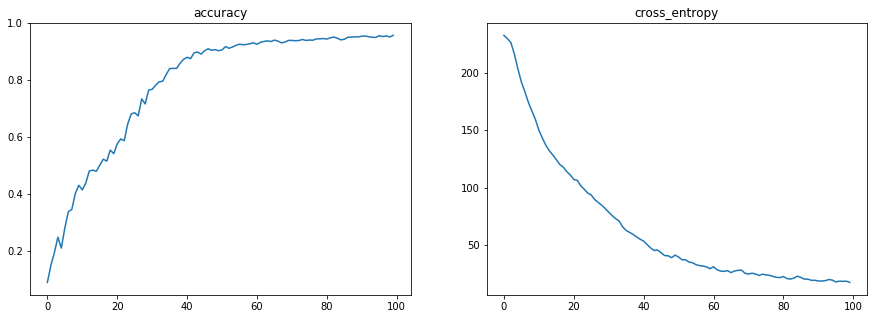

In [28]:
draw(a,c)

# 0.94???

![](images/fry.png)

### sigmoid + softmax + 5 layers
- Качество классификации: 0.94
- Медленно сходится
- Есть резкие перепады при обучении
- Нужна другая функция активации

# Relu = Rectified Linear Unit

![](images/relu.png)

```python
tf.nn.relu(tf.matmul(X,W1)+B1)
```

In [29]:
X =  tf.placeholder(tf.float32, [None, 784])

Y1 = tf.nn.relu(tf.matmul(X, W1) + B1)
Y2 = tf.nn.relu(tf.matmul(Y1, W2) + B2)
Y3 = tf.nn.relu(tf.matmul(Y2, W3) + B3)
Y4 = tf.nn.relu(tf.matmul(Y3, W4) + B4)

Ylogits = tf.matmul(Y4, W5) + B5
Y = tf.nn.softmax(Ylogits)
Y_ = tf.placeholder(tf.float32, [None, 10])

In [30]:
a, c = train_deep(X, Y, Ylogits, Y_)

Test: 0.1647000014781952, 226.0742645263672
Test: 0.9204999804496765, 26.77494239807129
Test: 0.9391999840736389, 20.49483871459961
Test: 0.953000009059906, 15.976889610290527
Test: 0.9564999938011169, 13.962605476379395
Test: 0.9606000185012817, 12.418688774108887
Test: 0.9613999724388123, 12.344167709350586
Test: 0.9634000062942505, 12.622851371765137
Test: 0.960099995136261, 13.433085441589355
Test: 0.9661999940872192, 11.935070991516113


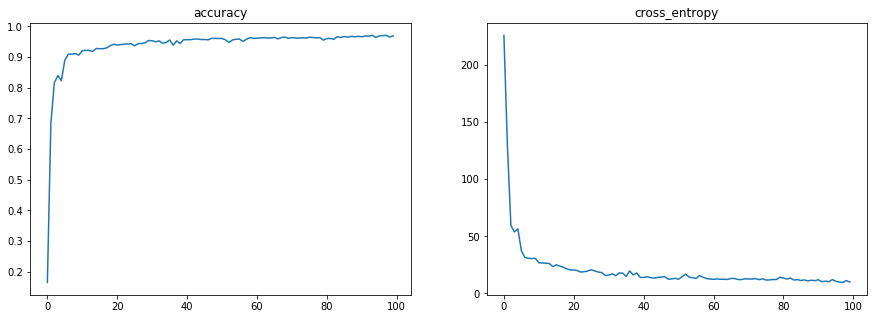

In [31]:
draw(a,c)

### relu + softmax + 5 layers

- качество классификации 0.97
- быстро сходится
- относительно стабильно??

In [32]:
a, c = train_deep(X, Y, Ylogits, Y_, 5000)

Test: 0.14419999718666077, 228.2206573486328
Test: 0.9193000197410583, 26.626399993896484
Test: 0.921999990940094, 26.062955856323242
Test: 0.9225000143051147, 24.187725067138672
Test: 0.9524000287055969, 15.917776107788086
Test: 0.9563999772071838, 13.650592803955078
Test: 0.9650999903678894, 11.619589805603027
Test: 0.9623000025749207, 12.328930854797363
Test: 0.9704999923706055, 9.90969467163086
Test: 0.968500018119812, 10.409608840942383
Test: 0.9639000296592712, 11.868613243103027
Test: 0.9728000164031982, 9.583634376525879
Test: 0.9699000120162964, 10.106823921203613
Test: 0.9704999923706055, 9.33514404296875
Test: 0.9678999781608582, 10.709968566894531
Test: 0.9690999984741211, 10.103565216064453
Test: 0.9688000082969666, 10.650016784667969
Test: 0.9746999740600586, 8.89111042022705
Test: 0.9740999937057495, 9.634437561035156
Test: 0.9733999967575073, 9.40545654296875
Test: 0.9735999703407288, 9.46670150756836
Test: 0.9736999869346619, 9.855304718017578
Test: 0.9754999876022339,

# Шумы в кривой точности

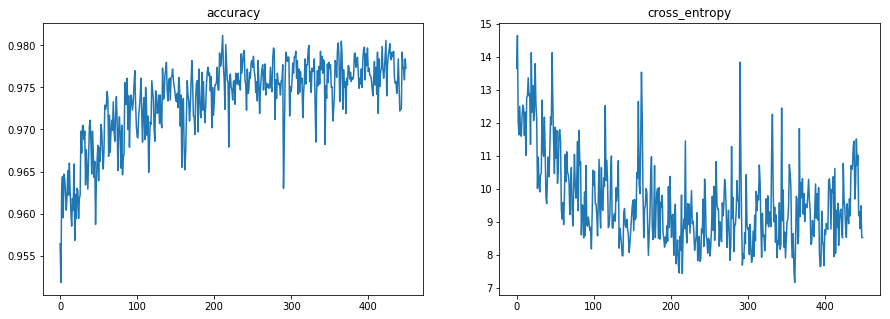

In [33]:
draw(a[50:], c[50:])

# Learning rate decay

- замедлять скорость обучения по ходу обучения

```
max_learning_rate = 0.003
min_learning_rate = 0.0001
decay_speed = 2000.0
learning_rate = min_learning_rate + (max_learning_rate - min_learning_rate) * math.exp(-i/decay_speed)
```

In [34]:
def train_lr_decay(X, Y, Ylogits, Y_, epoches=1000):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=Ylogits, labels=Y_)
    cross_entropy = tf.reduce_mean(cross_entropy)*100
    
    is_correct = tf.equal(tf.argmax(Y,1), tf.argmax(Y_,1))
    accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

    max_learning_rate = 0.003
    min_learning_rate = 0.0001
    decay_speed = 2000.0
    learning_rate = tf.placeholder(tf.float32)
    
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train_step = optimizer.minimize(cross_entropy)

    accuracy_vis, cross_entropy_vis = [], []
    
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        for i in range(epoches):
            batch_X, batch_Y = mnist.train.next_batch(100)
            
            lr = min_learning_rate + (max_learning_rate - min_learning_rate) * math.exp(-i/decay_speed)
            train_data={X: batch_X, Y_: batch_Y, learning_rate: lr}

            # train
            sess.run(train_step, feed_dict=train_data)

            if i % 10 == 0:
                test_data={X: mnist.test.images, Y_: mnist.test.labels}
                a, c = sess.run([accuracy, cross_entropy], feed_dict=test_data)
                accuracy_vis.append(a)
                cross_entropy_vis.append(c)
                if i % 500 == 0:
                    print("Test: {}, {}".format(a, c))
    return (accuracy_vis, cross_entropy_vis)

In [35]:
a, c = train_lr_decay(X, Y, Ylogits, Y_, 10000)

Test: 0.1859000027179718, 227.35543823242188
Test: 0.9544000029563904, 14.740668296813965
Test: 0.9699000120162964, 9.963876724243164
Test: 0.9735999703407288, 9.058289527893066
Test: 0.9779999852180481, 7.636318206787109
Test: 0.9793999791145325, 7.169418811798096
Test: 0.9789000153541565, 7.904794216156006
Test: 0.9783999919891357, 7.831852912902832
Test: 0.9796000123023987, 8.334189414978027
Test: 0.9797999858856201, 8.294150352478027
Test: 0.9807000160217285, 8.431187629699707
Test: 0.9810000061988831, 8.371230125427246
Test: 0.9807999730110168, 8.59482479095459
Test: 0.9807000160217285, 8.825003623962402
Test: 0.98089998960495, 9.139716148376465
Test: 0.9807000160217285, 9.22861099243164
Test: 0.9807999730110168, 9.49561882019043
Test: 0.9811000227928162, 9.663046836853027
Test: 0.9805999994277954, 9.864192962646484
Test: 0.9810000061988831, 10.201659202575684


# Переобучение

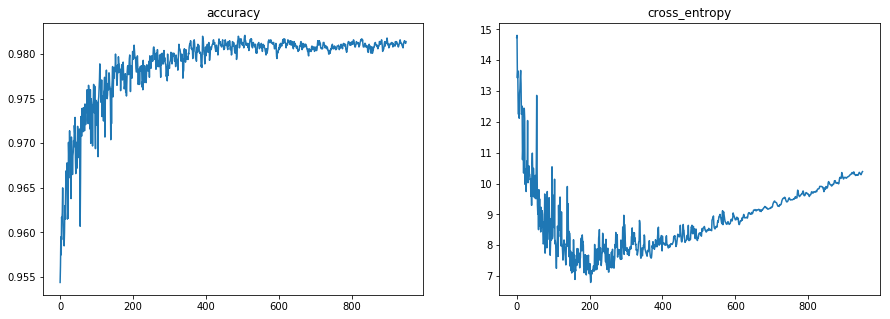

In [36]:
draw(a[50:], c[50:])

# Drop Out

![](images/dropout.png)

```python
pkeep = tf.placeholder(tf.float32)
Y1d = tf.nn.dropout(Y1, pkeep)

train_data={X: batch_X, Y_: batch_Y, learning_rate: lr, pkeep: 0.75}
test_data={X: mnist.test.images, Y_: mnist.test.labels, pkeep: 1.0}
```

In [37]:
def train_lr_decay_dropout(X, Y, Ylogits, Y_, pkeep, epoches=1000):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=Ylogits, labels=Y_)
    cross_entropy = tf.reduce_mean(cross_entropy)*100
    
    is_correct = tf.equal(tf.argmax(Y,1), tf.argmax(Y_,1))
    accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

    max_learning_rate = 0.003
    min_learning_rate = 0.0001
    decay_speed = 2000.0
    learning_rate = tf.placeholder(tf.float32)
    
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train_step = optimizer.minimize(cross_entropy)

    accuracy_vis, cross_entropy_vis = [], []
    
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        for i in range(epoches):
            batch_X, batch_Y = mnist.train.next_batch(100)
            
            lr = min_learning_rate + (max_learning_rate - min_learning_rate) * math.exp(-i/decay_speed)
            train_data={X: batch_X, Y_: batch_Y, learning_rate: lr, pkeep: 0.75}

            # train
            sess.run(train_step, feed_dict=train_data)

            if i % 10 == 0:
                test_data={X: mnist.test.images, Y_: mnist.test.labels, pkeep: 1.0}
                a, c = sess.run([accuracy, cross_entropy], feed_dict=test_data)
                accuracy_vis.append(a)
                cross_entropy_vis.append(c)
                if i % 500 == 0:
                    print("Test: {}, {}".format(a, c))
    return (accuracy_vis, cross_entropy_vis)

In [38]:
pkeep = tf.placeholder(tf.float32)

X =  tf.placeholder(tf.float32, [None, 784])

Y1 = tf.nn.dropout(tf.nn.relu(tf.matmul(X, W1) + B1), pkeep)
Y2 = tf.nn.dropout(tf.nn.relu(tf.matmul(Y1, W2) + B2), pkeep)
Y3 = tf.nn.dropout(tf.nn.relu(tf.matmul(Y2, W3) + B3), pkeep)
Y4 = tf.nn.dropout(tf.nn.relu(tf.matmul(Y3, W4) + B4), pkeep)

Ylogits = tf.matmul(Y4, W5) + B5
Y = tf.nn.softmax(Ylogits)
Y_ = tf.placeholder(tf.float32, [None, 10])

In [39]:
a, c = train_lr_decay_dropout(X, Y, Ylogits, Y_, pkeep, 10000)

Test: 0.13210000097751617, 227.8106689453125
Test: 0.9544000029563904, 16.029678344726562
Test: 0.9645000100135803, 12.972384452819824
Test: 0.9684000015258789, 11.261515617370605
Test: 0.9739999771118164, 9.899155616760254
Test: 0.9739999771118164, 9.44610595703125
Test: 0.9740999937057495, 10.034586906433105
Test: 0.9758999943733215, 9.311582565307617
Test: 0.9785000085830688, 9.393570899963379
Test: 0.9781000018119812, 9.309616088867188
Test: 0.979200005531311, 8.980360984802246
Test: 0.9786999821662903, 8.907164573669434
Test: 0.9789000153541565, 8.919472694396973
Test: 0.9796000123023987, 9.136421203613281
Test: 0.9800999760627747, 8.896743774414062
Test: 0.9789999723434448, 9.251812934875488
Test: 0.980400025844574, 9.065969467163086
Test: 0.9796000123023987, 9.546613693237305
Test: 0.9800999760627747, 9.150278091430664
Test: 0.9801999926567078, 9.352210998535156


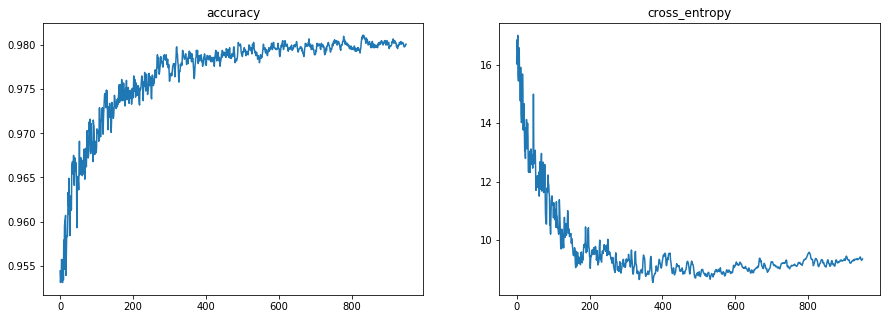

In [40]:
draw(a[50:], c[50:])

![](images/dropout_fan.png)

*[copyright: alexpokusay / 123RF stock photos](https://fr.123rf.com/profile_alexpokusay)*